# CS-502 Homework 2: Graph Neural Networks

In this notebook, we will explore various aspects of graph-based machine learning using the MUTAG dataset. The MUTAG dataset is a widely used graph classification dataset in the field of cheminformatics. It is designed for predicting the mutagenicity of chemical compounds, making it a crucial resource for toxicology and drug discovery research.

## 1. Setup
Importing the necessary libraries. 

In [1]:
%matplotlib inline
import sys
import time
import pandas as pd
import seaborn as sns
import networkx as nx
import numpy as np
from scipy import sparse as sp
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import load_dataset
from torch_geometric.data import Data, DataLoader
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from torch_geometric.data import Batch
from torch_geometric import loader
from itertools import product 
from IPython.display import clear_output
import csv

In [2]:
# this function will be used to skip the execution of the hyperparameter search,
# because it takes a lot of time and it is not necessary to run it every time
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    """Skip execution of the current cell."""
    return

## 2. Data

### Downloading the data
The data can be found [here](https://huggingface.co/datasets/graphs-datasets/MUTAG). The dataset comprises a total of 188 small graphs, each representing a molecule.

For this exercise, we will use only the training partition, and we will treat as the entire dataset.

The goal of this assignment is to develop and evaluate graph convolutional network models for the graph classification task, by predicting whether a chemical compound is mutagenic or non-mutagenic.

In [3]:
dataset = load_dataset("graphs-datasets/MUTAG")
dataset_pg_list = []
dataset_pg_list_edge = []

for example in dataset["train"]:
    x = example['node_feat']
    edge_index = example['edge_index']
    edge_attr= example['edge_attr']
    edge_attr_tensor = torch.tensor(example['edge_attr'], dtype=torch.float32) 
    y = example['y']
    num_nodes = example['num_nodes']

    # computing an adjacency matrix from edge_index
    adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
    adj_matrix[edge_index[0], edge_index[1]] = 1.0

    # computing an adjacency matrix from edge_index and edge_attr for when we want to use edge features
    adj_matrix_edges = torch.zeros((num_nodes, num_nodes, edge_attr_tensor.shape[1]), dtype=torch.float32)
    for idx, (src, tgt) in enumerate(zip(edge_index[0], edge_index[1])):
        adj_matrix_edges[src, tgt] = edge_attr_tensor[idx]
    
    # creating a PyTorch Geometric Data object
    data_nodes = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, num_nodes=num_nodes, adj_matrix=adj_matrix)
    data_nodes_edge = Data(x=x, edge_index=edge_index, edge_attr=edge_attr_tensor, y=y, num_nodes=num_nodes, adj_matrix=adj_matrix_edges)
    
    dataset_pg_list.append(data_nodes)
    dataset_pg_list_edge.append(data_nodes_edge)

# creating DataLoaders from the list of data objects
batch_size = 1  # desired batch size
dataset_pg = loader.DataLoader(dataset_pg_list, batch_size=batch_size, shuffle=False)
dataset_pg_edge = loader.DataLoader(dataset_pg_list_edge, batch_size=batch_size, shuffle=False)

When using only node features, the adjacency matrices will have dimensionality (num_nodes, num_nodes), while when using both node and edge featues, the adjacency matrices will have dimensionality (num_nodes, num_nodes, num_edge_features)

### Data Partitioning

In [4]:
mutagenic=0
non_mutagenic=0
for batch in dataset_pg:
    if batch.y[0][0]==0:
        non_mutagenic+=1
    else:
        mutagenic+=1
print("Number of mutagenic graphs: ", mutagenic)
print("Number of non-mutagenic graphs: ", non_mutagenic)

Number of mutagenic graphs:  125
Number of non-mutagenic graphs:  63


As we can see the dataset is imbalanced. Stratified splitting ensures that the train, validation, and test sets have the same proportion of mutagenic and non-mutagenic graphs as the original dataset. This is crucial for maintaining a consistent representation of the classes across splits to prevent introducing biases and to better evaluate the model's performance on both classes.

In [5]:
def data_partitioning_stratified(dataset, train_ratio, test_ratio, batch_size):
    """
    Stratified partition the dataset into train, validation, and test sets.
    
    Args:
        dataset (list): Input dataset.
        train_ratio (float): Ratio of training data.
        test_ratio (float): Ratio of test data.
        batch_size (int): Batch size for DataLoader.

    Returns:
        DataLoader: Training DataLoader instance.
        DataLoader: Validation DataLoader instance.
        DataLoader: Test DataLoader instance.
    """
    
    # extract y values from the dataset in order to stratify the splitting
    # this will make the model more robust to class imbalance
    ys = [data.y for data in dataset]

    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    test_size = int(test_ratio * total_size)
    val_size = total_size - train_size - test_size

    # get indices for stratified splitting
    sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, test_size=test_size + val_size, random_state=19)
    train_idx, temp_idx = next(sss.split(ys, ys))

    # split temp_idx into validation and test sets
    test_size_ratio = test_size / (test_size + val_size)
    sss = StratifiedShuffleSplit(n_splits=1, train_size=test_size_ratio, test_size=1-test_size_ratio, random_state=19)
    test_idx, val_idx = next(sss.split([ys[i] for i in temp_idx], [ys[i] for i in temp_idx]))

    test_idx = [temp_idx[i] for i in test_idx]
    val_idx = [temp_idx[i] for i in val_idx]

    # use the indices to slice the dataset
    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    test_dataset = Subset(dataset, test_idx)

    # collate function for DataLoader
    def collate_fn(batch):
        return Batch.from_data_list(batch)

    # creating DataLoader instances for each split
    train_loader = loader.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    val_loader = loader.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = loader.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader


In [6]:
# creating train, validation, and test loaders for when we want to use node features only
train_loader, val_loader, test_loader = data_partitioning_stratified(dataset_pg_list, 0.7, 0.15, batch_size)

print(f"Number of training graphs: {len(train_loader)}")
print(f"Number of validation graphs: {len(val_loader)}")
print(f"Number of test graphs: {len(test_loader)}")

Number of training graphs: 131
Number of validation graphs: 29
Number of test graphs: 28


In [7]:
# creating train, validation, and test loaders for when we want to use edge features in addition to node features
train_loader_edge, val_loader_edge, test_loader_edge = data_partitioning_stratified(dataset_pg_list_edge, 0.7, 0.15, batch_size)

print(f"Number of training graphs: {len(train_loader_edge)}")
print(f"Number of validation graphs: {len(val_loader_edge)}")
print(f"Number of test graphs: {len(test_loader_edge)}")

Number of training graphs: 131
Number of validation graphs: 29
Number of test graphs: 28


### Let's visualize some of the graphs

In [8]:
def visualize_graphs(dataset, num_graphs, plot_title):
    num_rows = 2
    num_cols = 5
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 10))
    fig.subplots_adjust(wspace=0.2, hspace=0.2)
    fig.suptitle(plot_title, fontsize=18)

    for graph_index in range(min(num_graphs, len(dataset))):
        graph_data = dataset[graph_index]
        node_features = graph_data["node_feat"]
        edge_index = graph_data["edge_index"]
        edge_features = graph_data["edge_attr"]
        y = graph_data["y"]
        num_nodes = graph_data["num_nodes"]

        G = nx.Graph()

        for node_id, node_feat in enumerate(node_features):
            G.add_node(node_id, features=node_feat)

        for source, target in zip(edge_index[0], edge_index[1]):
            G.add_edge(source, target)

        # subplot coordinates
        row = graph_index // num_cols
        col = graph_index % num_cols

        node_colors = ['lightblue' if label == 0 else 'lightgreen' for label in y]

        pos = nx.spring_layout(G) 
        nx.draw( G, pos, with_labels=True, node_color=node_colors, node_size=300, font_size=8, ax=axes[row, col])
        axes[row, col].set_title(f"Graph {graph_index + 1} with {num_nodes} nodes and label {y[0]}")

    plt.show()


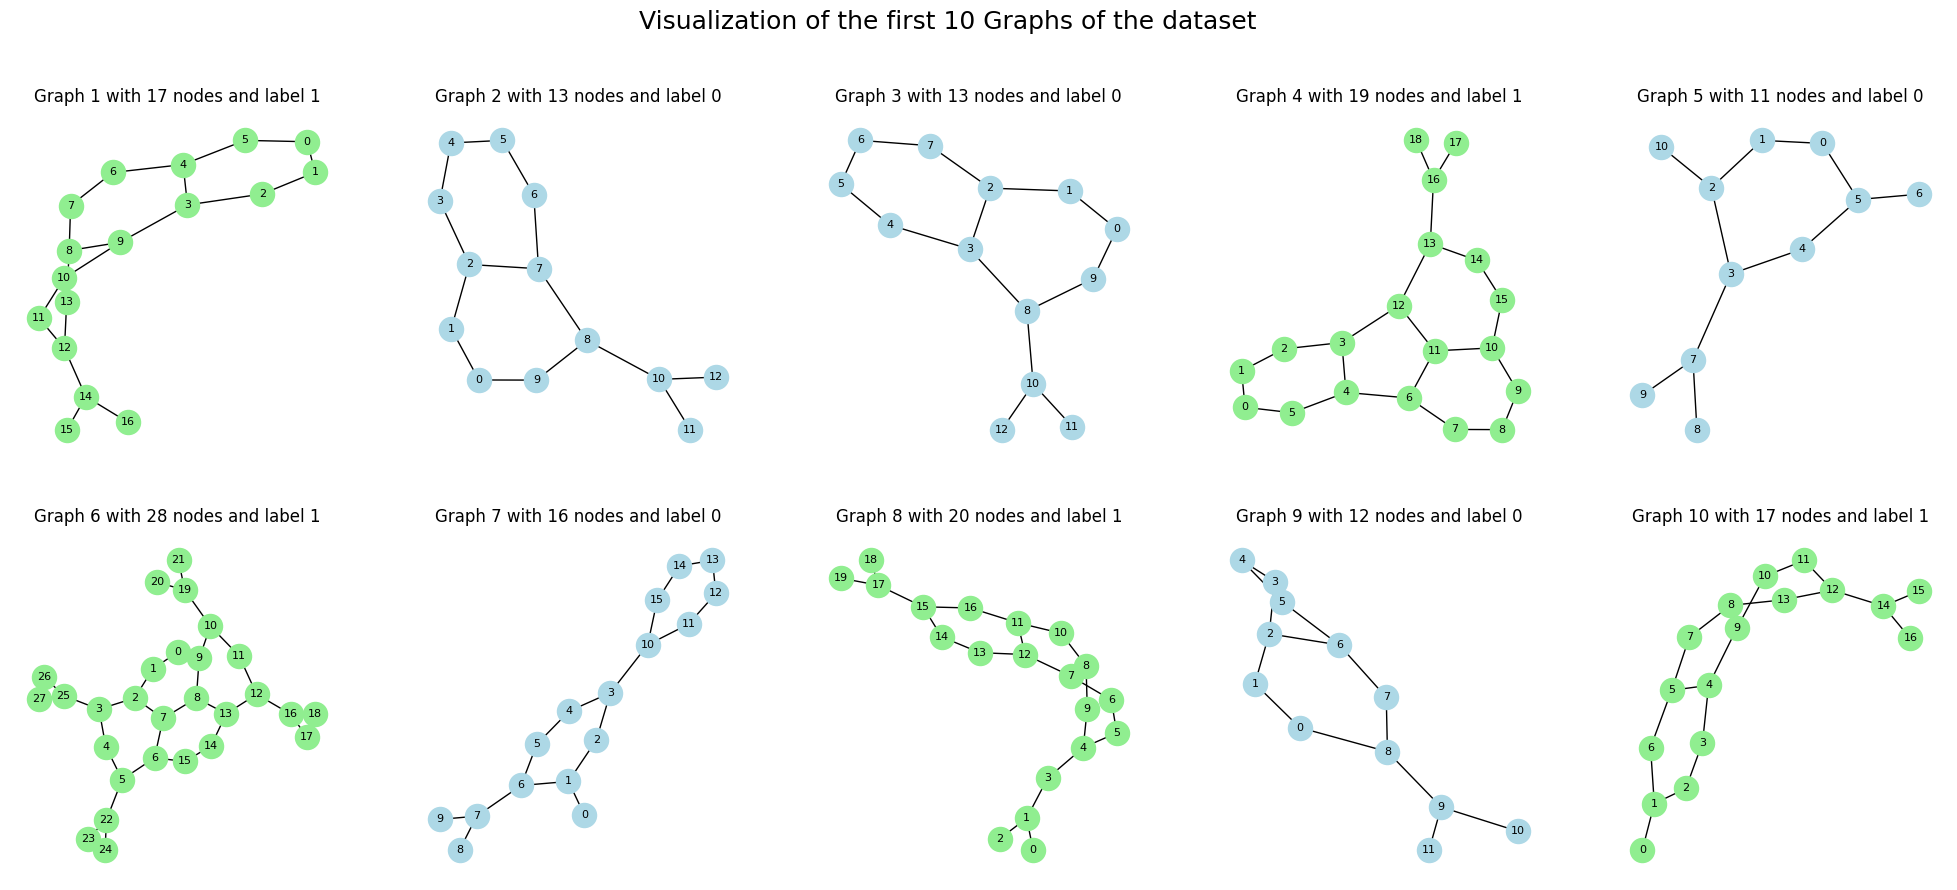

In [9]:
visualize_graphs(dataset["train"], 10, plot_title="Visualization of the first 10 Graphs of the dataset")

# Assignments

___

## Part 1: Implementing Different Graph Convolution and Pooling Layers

### 1. Normal Convolution (Graph Convolution)

We will start by implementing layers to perform graph convolutions with simple neighborhood aggregation. They will be useful to build the Deep Graph Encoder part of the whole GNN model.

The equation for such a layer is:
$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \sum_{u\in N(v)} \frac{\mathbf{h}_u^{(l)}}{|N(v)|} + \mathbf{B}_l \mathbf{h}_v^{(l)} \right),
$$
where $v$ index the node, $l$ the layer, $\mathbf{h}$ are the node embeddings, $\sigma$ is a non-linearity, $N(v)$ is the set of neighbor of node $v$, and $\mathbf{W}$ and $\mathbf{B}$ are the trainable weight matrices of the layer. Or, in matrix form with the adjacency matrix (corrected by the inverse of the degree) $\tilde{A}$:
$$
H^{(l+1)} = \sigma\left( \tilde{A}H^{(l)}W_l^\top + H^{(l)}B_l^\top \right).
$$


In [10]:
class GraphConv(nn.Module):
    """Basic graph convolutional layer implementing the simple neighborhood aggregation."""

    def __init__(self, in_features, out_features, activation=None):
        """
        Initialize the graph convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply
        """
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.activation = activation

        # learnable weight matrices, using linear layers
        self.weight = nn.Linear(in_features, out_features, bias=False)
        nn.init.xavier_uniform_(self.weight.weight)
        self.bias = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x, adj):
        """
        Perform graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        # neighbourhood aggregation
        adj = adj / adj.sum(1, keepdim=True).clamp(min=1)
        x_agg = torch.matmul(adj, x)

        # perform graph convolution
        x = self.weight(x_agg) + self.bias(x)

        # apply activation function
        if self.activation is not None:
            x = self.activation(x)
            
        return x

### 2. GraphSAGE (Customized Aggregation)

The equation for the GraphSAGE layer is:
$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \cdot \mathrm{CONCAT} \left[\mathbf{h}_v^{(l)}, \mathrm{AGG} \left(\left\{\mathbf{h}_u^{(l)}, \forall u\in N(v) \right\}\right) \right] \right),
$$
where $v$ index the node, $l$ the layer, $\mathbf{h}$ are the node embeddings, $\sigma$ is a non-linearity, $N(v)$ is the set of neighbor of node $v$, and $\mathbf{W}$ is the trainable weight matrix of the layer. $\mathrm{CONCAT}$ is the concatenation operation, while $\mathrm{AGG}$ is an arbitrary aggregation function.

In [11]:
class GraphSAGEConv(nn.Module):
    """GraphSAGE convolutional layer."""

    def __init__(self, in_features, out_features, aggregation, activation=None):
        """
        Initialize the GraphSAGE convolutional layer.

        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            aggregation (nn.Module or callable): aggregation function to apply, as x_agg = aggegration(x, adj).
            activation (nn.Module or callable): activation function to apply
        """
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.aggregation = aggregation
        self.activation = activation
        
        # after concatenating, the feature size is 2*in_features
        self.weight = nn.Linear(2 * in_features, out_features)
        nn.init.xavier_uniform_(self.weight.weight)

    def forward(self, x, adj):
        """
        Perform graphSAGE convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graphSAGE convolution, shape (num_nodes, out_features).
        """
        # aggregate neighbors features
        x_agg = self.aggregation(x, adj)
        
        # concatenate node's own features with aggregated neighbors features
        x_concat = torch.cat([x, x_agg], dim=-1)
        
        # apply linear transformation
        x = self.weight(x_concat)
        
        # apply activation function
        if self.activation is not None:
            x = self.activation(x)

        return x

Aggregation functions for the GraphSAGE layers:
1. MeanAggregation: average the neighbors, same as above,
2. MaxPoolAggregation: element-wise maximum over the neighbors,
3. SumAggregation: sum the neighbors,
4. SqrtDegAggregation: divide the sum of the neighbors by the square-root of the node degrees:  $$\mathrm{AGG} \left(\left\{\mathbf{h}_u^{(l)}, \forall u\in N(v) \right\}\right) = \sum_{u\in N(v)} \frac{\mathbf{h}_u^{(l)}}{\sqrt{\mathrm{deg}(v)}\sqrt{\mathrm{deg}(u)}}.$$


In [12]:
class MeanAggregation(nn.Module):
    """Aggregate node features by averaging over the neighborhood."""
    def __init__(self):
        super().__init__()

    def forward(self, x, adj):
        # normalize the adjacency matrix
        degree = torch.sum(adj, dim=1, keepdim=True).clamp(min=1)
        adj = adj / degree

        # aggregate neighborhood information using mean
        x_agg = torch.matmul(adj, x)

        return x_agg
    
class MaxPoolAggregation(nn.Module):
    """
    Aggregate node features by taking the maximum over the transformed neighborhood.
    """
    def __init__(self):
        super().__init__()

    def forward(self, x, adj):
        # aggregate neighborhood information using max-pooling
        edge_index = torch.triu(adj).nonzero(as_tuple=False).t()
        x_agg = torch.zeros_like(x)
        # loop on all nodes
        for i in range(x_agg.shape[0]):
            neighbors = x[edge_index[1, edge_index[0] == i]]
            if neighbors.shape[0] > 0:
                x_agg[i] = neighbors.max(dim=0)[0]

        return x_agg

class SumAggregation(nn.Module):
    """Aggregate node features by summing over the neighborhood."""
    def __init__(self):
        super().__init__()

    def forward(self, x, adj):
        # aggregate neighborhood information using sum
        x_agg = torch.matmul(adj, x)

        return x_agg

class SqrtDegAggregation(nn.Module):
    """Aggregate node features by summing over the neighborhood and normalizing by the degrees."""
    def __init__(self):
        super().__init__()

    def forward(self, x, adj):
        # compute the degree for each node
        degree = torch.sum(adj, dim=1, keepdim=True).clamp(min=1)
        
        # compute the square root of the node degrees for normalization
        sqrt_degree = torch.sqrt(degree)

        # aggregate and normalize by square root of degree
        x_agg = torch.matmul(adj, x) / sqrt_degree
        
        return x_agg

### 3. Attention-based Convolution

Implement an Attention-based Convolution layer for your GCN model. Attention-based Convolution applies attention mechanisms to neighbor aggregation. The equation for Attention-based Convolution at layer $( l )$ can be defined as follows:

$$
h_v^{'(l)} = W h_v^{(l)}
$$

$$
h_v^{(l+1)} = \sigma \left( \sum_{u \in N(v) \cup \{v\}} a_{vu}^{(l)} \cdot h_u^{'(l)} \right)
$$

where $( a_{vu}^{(l)})$ is the normalized attention weights between node $( v )$ and its neighbors node $( u )$ as well as itself, see below how they are computed. $( N(v) \cup \{v\} )$ is the union of the neighbors of node $( v )$ and itself.

The attention score $( e_{vu} )$ between node $( v )$ and its neighbor $( u )$ is calculated as the dot product between a learnable weight vector and the concatenation of their features and passed through a LeakyReLU activation:

$$
e_{vu} = \text{LeakyReLU} \left( S^T \cdot \text{CONCAT} \left( h_v^{'(l)}, h_u^{'(l)} \right) \right)
$$

where $( S )$ is a learnable weight vector, shared amongst all nodes. Note that this attention score is applied to the transformed node embedding $( h_v^{'(l)} )$.

After calculating the attention scores, we apply the softmax function to obtain normalized attention weights. These weights represent the importance of each neighbor node in relation to node $( v )$:

$$
a_{vu} = \frac{\exp(e_{vu})}{\sum_{k \in N(v) \cup \{v\}} \exp(e_{vk})}
$$


In [13]:
class AttentionConv(nn.Module):
    """Attention Convolution layer"""
    def __init__(self, in_features, out_features):
        """
        Initialize the Attention convolutional layer.

        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply
        """
        super().__init__()

        self.in_features = in_features
        self.out_features = out_features

        # weight matrices
        self.W = nn.Parameter(torch.Tensor(in_features, out_features))
        nn.init.xavier_uniform_(self.W.data)
        # attention mechanism parameters
        self.a = nn.Parameter(torch.Tensor(2 * out_features, 1))
        nn.init.xavier_uniform_(self.a.data)

        self.leakyrelu = nn.LeakyReLU()

    def forward(self, x, adj):
        """ 
        Perform attention convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (num_nodes, num_nodes).
        Returns:
            Tensor: Output node features after attention convolution, shape (num_nodes, out_features). 
        """
        
        # linear transformation of the input features using weight matrix W
        x_prime = torch.mm(x, self.W)
        N = x_prime.size()[0]

        # creating concatenated feature pairs for every combination of nodes in the graph and reshaping
        x_prime_rowwise = x_prime.repeat(1, N).view(N * N, -1)
        x_prime_full = x_prime.repeat(N, 1)
        conc = torch.cat([x_prime_rowwise, x_prime_full], dim=1).view(N, -1, 2 * x_prime.size(1))

        # attention scores
        e = self.leakyrelu(torch.matmul(conc, self.a).squeeze(2))

        # masking to exclude self attention
        I = torch.eye(N, device=adj.device)
        e = e.masked_fill(I.bool(), float('-inf'))

        # compute attention weights
        attention = F.softmax(e, dim=1)

        # aggregate neighbor information
        x = torch.matmul(attention, x_prime)

        return x

### 4. Mean Pooling

Given a graph with node features $X \in \mathbb{R}^{N \times D}$, where $N$ is the number of nodes and $D$ is the feature dimension, mean pooling computes the graph-level representation $h_{\text{global}}$ as the mean (average) of all node features:

$$
h_{\text{global}} = \frac{1}{N} \sum_{i=1}^{N} X_i
$$

Here, $X_i$ represents the feature vector of the $i^{th}$ node.


In [14]:
def mean_pooling(x):
    """
    Compute graph-level representation using mean pooling.
 
    Args:
        x (Tensor): Input node features of shape (num_nodes, in_features).
 
    Returns:
        Tensor: Graph-level representation (mean of all node features) of shape (in_features,).
    """
    h_global = torch.mean(x, dim=0)
    return h_global

### 5. Max Pooling 

Max pooling selects the maximum value from each feature dimension across all nodes to create the graph-level representation:

$$
h_{\text{global}}[d] = \max_{i=1}^{N} X_i[d]
$$

for each feature dimension $(d)$.


In [15]:
def max_pooling(x):
    """
    Compute graph-level representation using max pooling.
 
    Args:
        x (Tensor): Input node features of shape (num_nodes, in_features).
 
    Returns:
        Tensor: Graph-level representation (max of all node features) of shape (in_features,).
    """
    h_global, _ = torch.max(x, dim=0, keepdim=True)
    return h_global

___

## Part 2: Custom Network Design with Node Features

### GNN full model (Custom Network Architecture)

In [16]:
class GNN(nn.Module):
    """Graph Neural Network for graph classification."""

    def __init__(self, num_features, conv_dims, activation, pooling='mean', layer_type="GraphConv", dropout=0):
        """
        Initialize the GNN model for graph classification.

        Args:
            num_features (int): Number of input node features.
            conv_dims (list of int): Number of hidden features in each graph convolution layer.
            activation (nn.Module or callable): Activation function to apply.
            pooling (str): Pooling type ('mean' or 'max') in the prediction head. (optional)
            layer_type (str): Type of graph convolutional layer to use. (optional)
            dropout (float): Dropout probability. (optional)
        """
        super().__init__()
        
        self.num_features = num_features
        self.conv_dims = conv_dims
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        
        # pooling layer (either Mean or Max)
        if pooling == 'mean':
            self.pooling = mean_pooling
        elif pooling == 'max':
            self.pooling = max_pooling
        else:
            raise ValueError("Invalid pooling type. Use 'mean' or 'max'.")
        
        # a list of graph convolutional layers based on conv_dims
        self.conv_layers = nn.ModuleList()
        
        # choose a type of graph convolutional layer
        if layer_type == "GraphConv":
            self.conv_layers.append(GraphConv(num_features, conv_dims[0], activation))
            for i in range(len(conv_dims) - 2):
                self.conv_layers.append(GraphConv(conv_dims[i], conv_dims[i+1], activation))
            self.conv_layers.append(GraphConv(conv_dims[-2], conv_dims[-1], None))

        elif layer_type == "GraphSAGEConv":
            self.conv_layers.append(GraphSAGEConv(num_features, conv_dims[0], MaxPoolAggregation(), F.relu))
            for i in range(len(conv_dims) - 2):
                self.conv_layers.append(GraphSAGEConv(conv_dims[i], conv_dims[i+1], MaxPoolAggregation(), activation))
            self.conv_layers.append(GraphSAGEConv(conv_dims[-2], conv_dims[-1], MaxPoolAggregation(), None))

        elif layer_type == "AttentionConvolution":
            self.conv_layers.append(AttentionConv(num_features, conv_dims[0]))
            for i in range(len(conv_dims) - 2):
                self.conv_layers.append(AttentionConv(conv_dims[i], conv_dims[i+1]))
            self.conv_layers.append(AttentionConv(conv_dims[-2], conv_dims[-1]))

        else:
            raise ValueError("Invalid layer type. Use 'GraphConv', 'GraphSAGEConv', or 'AttentionConvolution'.")

        # batch normalization layers to help with training
        self.norms = nn.ModuleList()
        for dim in conv_dims:
            self.norms.append(nn.BatchNorm1d(dim))
        
        # fully connected Layer for prediction with 1 output
        self.fc = nn.Linear(conv_dims[-1], 1)

    def forward(self, x, adj):
        """
        Perform forward pass of the model.

        Args:
            x (Tensor): Input node features of shape (num_nodes, num_features).
            adj (Tensor): Adjacency matrix of the graph, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output scores (logits) for each graph.
        """
        # apply graph convolutional layers with activation and dropout
        for conv_layer in self.conv_layers:
            x = self.activation(conv_layer(x, adj))
            x = self.dropout(x)
        
        # apply pooling
        x = self.pooling(x)
        
        # apply fully connected layer
        x = self.fc(x)
        
        return x

### Training

Training one simple model using only the node features to make sure that the model is training properly.

In [17]:
def train(model, train_loader, optimizer, criterion=nn.BCEWithLogitsLoss()):
    """ Training for the model.
    Args:
        model (nn.Module): Model to be trained.
        train_loader (DataLoader): Training DataLoader instance.
        optimizer (optim.Optimizer): Optimizer for model parameters.
        criterion (nn.Module): Loss function.
    Returns:
        float: Training loss.
        float: Training accuracy.
        float: Training F1 score.
    """

    # setting the model to train phase
    model.train()
    train_loss = 0.0
    train_labels_list = []
    train_preds_list = []
    for batch in train_loader:
        x = torch.tensor(batch.x[0], dtype=torch.float32)
        adj = batch.adj_matrix.clone().detach()
        labels = torch.tensor(batch.y, dtype=torch.float32)

        outputs = model(x, adj)
        outputs = outputs.view(-1, 1)
        loss = criterion(outputs, labels.view(-1, 1).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        train_labels_list.extend(labels.cpu().numpy().tolist())
        train_preds_list.extend(preds.cpu().numpy().tolist())

    train_acc = accuracy_score(train_labels_list, train_preds_list)
    train_f1 = f1_score(train_labels_list, train_preds_list)

    return train_loss/len(train_loader), train_acc, train_f1


def validation(model, val_loader, criterion=nn.BCEWithLogitsLoss()):
    """ Validation for the model.
    Args:
        model (nn.Module): Model to validate.
        val_loader (DataLoader): Validation DataLoader instance.
        criterion (nn.Module): Loss function.
    Returns:
        float: Validation loss.
        float: Validation accuracy.
        float: Validation F1 score.
    """

    # setting the model to eval phase
    model.eval()
    val_loss = 0.0
    val_labels_list = []
    val_preds_list = []
    with torch.no_grad():
        for batch in val_loader:
            x = torch.tensor(batch.x[0], dtype=torch.float32)
            adj = batch.adj_matrix.clone().detach()
            labels = torch.tensor(batch.y, dtype=torch.float32)

            outputs = model(x, adj)
            outputs = outputs.view(-1, 1)
            val_loss += criterion(outputs, labels.view(-1, 1).float()).item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            val_labels_list.extend(labels.cpu().numpy().tolist())
            val_preds_list.extend(preds.cpu().numpy().tolist())

        val_acc = accuracy_score(val_labels_list, val_preds_list)
        val_f1 = f1_score(val_labels_list, val_preds_list)
    
    return val_loss/len(val_loader), val_acc, val_f1

In [18]:
def train_and_val(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    """ Training and Validation loop for the model.
    Args:
        model (nn.Module): Model to train and validate.
        criterion (nn.Module): Loss function.
        optimizer (optim.Optimizer): Optimizer for model parameters.
        train_loader (DataLoader): Training DataLoader instance.
        val_loader (DataLoader): Validation DataLoader instance.
        num_epochs (int): Number of epochs to train.
    Returns:
        dict: Dictionary of training and validation losses, accuracies, and F1 scores.
    """

    results = {
        "train_losses": [],
        "val_losses": [],
        "train_accuracies": [],
        "val_accuracies": [],
        "train_f1_scores": [],
        "val_f1_scores": [],
    }

    for epoch in range(num_epochs):
        # training Phase
        train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion)
        results["train_losses"].append(train_loss)
        results["train_accuracies"].append(train_acc)
        results["train_f1_scores"].append(train_f1)

        # validation Phase
        val_loss, val_acc, val_f1 = validation(model, val_loader, criterion)
        results["val_losses"].append(val_loss/len(val_loader))
        results["val_accuracies"].append(val_acc)
        results["val_f1_scores"].append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {results['train_losses'][-1]}, Validation Loss: {results['val_losses'][-1]}")
        print(f"Train Accuracy: {train_acc}, Validation Accuracy: {val_acc}")
        print(f"Train F1 Score: {train_f1}, Validation F1 Score: {val_f1}")

    return results

In [19]:
num_features = 7  # number of input node features
# num_edge_features = 4  # number of edge features
conv_dims = [8, 8]  # list of hidden features in each graph convolution layer
activation = nn.ReLU()  # activation function 
dropout = 0.0  # dropout probability
pooling = 'max'  # pooling type ('mean' or 'max')
criterion = nn.BCEWithLogitsLoss() # loss function
learning_rate = 0.01 # learning rate
num_epochs = 30 # the number of training epochs

# initializing the GNN model
baseline_model_nodes = GNN(num_features=num_features, conv_dims=conv_dims, activation=activation, dropout=dropout, pooling=pooling, layer_type="GraphConv")
optimizer = optim.Adam(baseline_model_nodes.parameters(), lr=learning_rate) 

In [20]:
results = train_and_val(baseline_model_nodes, criterion, optimizer, train_loader, val_loader, num_epochs)
#torch.save(baseline_model_nodes.state_dict(), f"baseline_nodes_model_1.pt")

Epoch 1/30, Loss: 0.6565007860878952, Validation Loss: 0.022231856155055317
Train Accuracy: 0.6335877862595419, Validation Accuracy: 0.6551724137931034
Train F1 Score: 0.7735849056603773, Validation F1 Score: 0.7916666666666666
Epoch 2/30, Loss: 0.6479170827465203, Validation Loss: 0.02209572403666239
Train Accuracy: 0.6641221374045801, Validation Accuracy: 0.6551724137931034
Train F1 Score: 0.798165137614679, Validation F1 Score: 0.7916666666666666
Epoch 3/30, Loss: 0.6488389275001205, Validation Loss: 0.021915361976226642
Train Accuracy: 0.6641221374045801, Validation Accuracy: 0.6551724137931034
Train F1 Score: 0.7962962962962963, Validation F1 Score: 0.7916666666666666
Epoch 4/30, Loss: 0.632101955304619, Validation Loss: 0.020952469599516296
Train Accuracy: 0.6641221374045801, Validation Accuracy: 0.6896551724137931
Train F1 Score: 0.7962962962962963, Validation F1 Score: 0.7999999999999999
Epoch 5/30, Loss: 0.5533118788295119, Validation Loss: 0.023331910584401008
Train Accuracy:

The changes in accuracy and F1 score from one epoch to another, as well as the repeated results, are likely because our dataset is quite small. With not so many grphs, our model might struggle to learn a consistent pattern. Also, with only 29 validation nodes, if even one node is misclassified, it can lead to a big change in the accuracy and F1 score. 

### Hyperparameter Tuning

Exploring various ways to set up the network to see which one gives the best results by trying different configurations of number of layers, hidden features, learning rates, type of convolutional layers, and pooling methods. By testing these different combinations of settings, the aim is to find the one that makes the model perform at its best on the training and validation sets overall, and for evert layer type.


In [21]:
%%skip

hyperparameters_nodes = []

hidden_features = [8, 16, 32]
num_layers_options = [2, 3, 4]

conv_dims = []
for num_layers in num_layers_options:
    for combination in product(hidden_features, repeat=num_layers):
        conv_dims.append(list(combination))

hyperparameters = {
    "conv_dims": conv_dims,
    "learning_rate": [0.01, 0.001],
    "layer_type": ["GraphConv", "GraphSAGEConv", "AttentionConvolution"],
    "pooling": ["mean", "max"],
}

num_epochs = 30

# a dictionary to store the best F1 scores and parameters for each layer type
best_val_f1_by_layer = {
    "GraphConv": float(0),
    "GraphSAGEConv": float(0),
    "AttentionConvolution": float(0)
}
best_params_by_layer = {}

# the overall best F1 score
best_val_f1 = float(0)

for lt in hyperparameters["layer_type"]:
    for lr in hyperparameters["learning_rate"]:
        for cd in hyperparameters["conv_dims"]:
            for pooling in hyperparameters["pooling"]:

                model = GNN(
                    num_features=7,
                    conv_dims=cd,
                    activation=nn.ReLU(),
                    layer_type=lt,
                    pooling=pooling,
                )
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                best_val_f1_model = 0
                best_val_f1_model_accuracy = 0
                best_train_f1_model = 0
                best_train_f1_model_accuracy = 0

                for epoch in range(num_epochs):
                    train_loss, train_accuracy, train_f1 = train(model, train_loader, optimizer)
                    val_loss, val_accuracy, val_f1 = validation(model, val_loader)

                    print(
                        f"Epoch {epoch+1}/{num_epochs}, Train F1: {train_f1}, Train Accuracy: {train_accuracy}, Val F1: {val_f1}, Val Accuracy: {val_accuracy}"
                    )

                    # check against overall best F1 score and save the model if it's better
                    if val_f1 > best_val_f1:
                        best_val_f1 = val_f1
                        torch.save(model.state_dict(), "best_nodes_model_1.pt")
                        
                    # check against best F1 score for the current layer type
                    if val_f1 > best_val_f1_by_layer[lt]:
                        best_val_f1_by_layer[lt] = val_f1
                        best_params_by_layer[lt] = (lr, cd, pooling)
                        torch.save(model.state_dict(), f"best_nodes_model_1_{lt}.pt")

                    if val_f1 > best_val_f1_model:
                        best_val_f1_model = val_f1
                        best_val_f1_model_accuracy = val_accuracy
                        best_train_f1_model = train_f1
                        best_train_f1_model_accuracy = train_accuracy

                results = {
                    "learning_rate": lr,
                    "layer_type": lt,
                    "conv_dims": cd,
                    "pooling": pooling,
                    "train_loss": train_loss,
                    "train_accuracy": train_accuracy,
                    "train_f1": train_f1,
                    "val_loss": val_loss,
                    "val_accuracy": best_val_f1_model_accuracy,
                    "val_f1": best_val_f1_model,
                }
                # saving the results for each combination of hyperparameters
                hyperparameters_nodes.append(results)
                clear_output()

In [22]:
%%skip
# save all hyperparameter combinations with their results in a csv file
with open('hyperparameters_nodes_1.csv', 'w', newline='') as csvfile:
    fieldnames = ['learning_rate', 'layer_type', 'conv_dims', 'pooling', 'train_loss', 'train_accuracy', 'train_f1', 'val_loss', 'val_accuracy', 'val_f1']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in hyperparameters_nodes:
        writer.writerow(row)

In [23]:
# these parameters are the best ones for each layer type after the hyperparameter tuning
# they are saved so we can use them without executing the hyperparameter tuning again
best_params_by_layer = {
    'GraphConv': (0.001, [8, 32, 32], 'mean'),
    'GraphSAGEConv': (0.01, [32, 8, 8, 32], 'mean'),
    'AttentionConvolution': (0.01, [8, 16, 16, 8], 'max')
    }

In [24]:
best_params_by_layer

{'GraphConv': (0.001, [8, 32, 32], 'mean'),
 'GraphSAGEConv': (0.01, [32, 8, 8, 32], 'mean'),
 'AttentionConvolution': (0.01, [8, 16, 16, 8], 'max')}

### Experimental results analysis and insights

To get better insight into the results, and make deeper analysis, we will visualize the impact of various hyperparameters on the results from the validation set. 

In [25]:
nodes_data = pd.read_csv('hyperparameters_nodes.csv')

First, we will explore how different layer types impact the results.

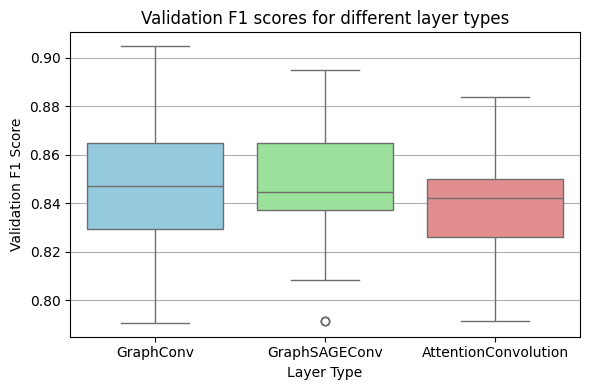

In [26]:
# plotting the F1 scores for each layer type in a boxplot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
colors = ["skyblue", "lightgreen", "lightcoral"]
sns.boxplot(data=nodes_data, x='layer_type', y='val_f1', ax=ax, hue='layer_type', palette=colors, legend=False)
ax.set_title("Validation F1 scores for different layer types")
ax.set_xlabel("Layer Type")
ax.set_ylabel("Validation F1 Score")
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

The plot shows the boxplots for the different layer types. According to the plot, the GraphConv layer type seems to have slightly higher median F1 score, followed closely by the GraphSAGEConv, and then the Attention Convolution.
Even though GraphConv has the highest median, it also has more variability in its scores as indicated by its broader IQR, while GraphSAGEConv and AttentionConvolution appear to have more consistent results, with tighter IQRs. However, we can see that the highest F1 score is achieved by using GraphConv layers.

Next, we will explore how does the depth of the network impact the performance of the model.

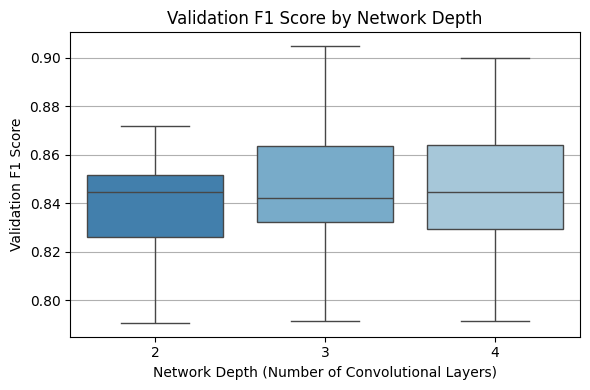

In [27]:
# plotting the F1 scores for each network depth in a boxplot
nodes_data['conv_depth'] = nodes_data['conv_dims'].apply(lambda x: len(eval(x)))
plt.figure(figsize=(6, 4))
sns.boxplot(data=nodes_data, x="conv_depth", y="val_f1", palette="tab20c", hue="conv_depth", legend=False)
plt.title("Validation F1 Score by Network Depth")
plt.ylabel("Validation F1 Score")
plt.xlabel("Network Depth (Number of Convolutional Layers)")
plt.gca().yaxis.grid(True)

plt.tight_layout()
plt.show()

From this visualization we can see that deeper networks (3 or 4 layers) generally tend to achieve slightly better performance. However, given that the graphs from the dataset are relatively small, even a 4-layer network might be too deep and we should be cautious about potential overfitting.

### Performance evaluation
Once we have our best models based on the performance on the *validation* set, and made deeper analysis on how different hyperparameters effect the performance of the model, we can do a final evaluation on the test set to get an idea of its predicting performance on new unseen data.


In [28]:
def test(model, criterion, test_loader, treshold):
    """ Testing the model performance.
    Args:
        model (nn.Module): Model to test.
        criterion (nn.Module): Loss function.
        test_loader (DataLoader): Test DataLoader instance.
        treshold (float): Threshold for binary classification.
    Returns:
        dict: Dictionary of test loss, accuracy, F1 score and confusion matrix.
    """

    results = {
        "test_losses": [],
        "test_accuracies": [],
        "test_f1_scores": [],
    }
    model.eval()
    test_loss = 0.0
    test_labels_list = []
    test_preds_list = []
    with torch.no_grad():
        for batch in test_loader:
            x = torch.tensor(batch.x[0], dtype=torch.float32)
            adj = batch.adj_matrix.clone().detach()
            labels = torch.tensor(batch.y, dtype=torch.float32)

            outputs = model(x, adj)
            outputs = outputs.view(-1, 1)
            test_loss += criterion(outputs, labels.view(-1, 1).float()).item()

            probs = torch.sigmoid(outputs)
            preds = (probs > treshold).float()
            test_labels_list.extend(labels.cpu().numpy().tolist())
            test_preds_list.extend(preds.cpu().numpy().tolist())

        test_acc = accuracy_score(test_labels_list, test_preds_list)
        test_f1 = f1_score(test_labels_list, test_preds_list)
        test_confusion_matrix = confusion_matrix(test_labels_list, test_preds_list)
        results["test_losses"].append(test_loss / len(test_loader))
        results["test_accuracies"].append(test_acc)
        results["test_f1_scores"].append(test_f1)
        results["test_confusion_matrix"] = test_confusion_matrix
        
    return results

—————— Simple Model ——————

In [29]:
# loading the Simple GNN model
baseline_model_nodes = GNN(
    num_features=num_features, 
    conv_dims=conv_dims, 
    activation=activation, 
    dropout=dropout, 
    pooling=pooling, 
    layer_type="GraphConv")
optimizer = optim.Adam(baseline_model_nodes.parameters(), lr=best_params_by_layer['GraphConv'][0]) 
baseline_model_nodes.load_state_dict(torch.load("baseline_nodes_model.pt"))

<All keys matched successfully>

In [30]:
# testing the Simple GNN model that we trained before
test_results_baseline_nodes = test(baseline_model_nodes, criterion, test_loader, 0.5)
print(f"Test Loss: {test_results_baseline_nodes['test_losses'][-1]}")
print(f"Test Accuracy: {test_results_baseline_nodes['test_accuracies'][-1]}")
print(f"Test F1 Score: {test_results_baseline_nodes['test_f1_scores'][-1]}")

Test Loss: 0.5331465556571077
Test Accuracy: 0.7857142857142857
Test F1 Score: 0.8235294117647058


—————— Best model - GraphConv ——————

In [31]:
# loading the best model for GraphConv layer type
best_nodes_model_GraphConv = GNN(
    num_features=num_features, 
    conv_dims=best_params_by_layer['GraphConv'][1], 
    activation=activation, 
    dropout=dropout, 
    pooling=best_params_by_layer['GraphConv'][2], 
    layer_type="GraphConv")
optimizer = optim.Adam(best_nodes_model_GraphConv.parameters(), lr=best_params_by_layer['GraphConv'][0]) 
best_nodes_model_GraphConv.load_state_dict(torch.load("best_nodes_model_GraphConv.pt"))

<All keys matched successfully>

In [32]:
test_results_graphconv_nodes = test(best_nodes_model_GraphConv, criterion, test_loader, 0.5)
print(f"Test Loss: {test_results_graphconv_nodes['test_losses'][-1]}")
print(f"Test Accuracy: {test_results_graphconv_nodes['test_accuracies'][-1]}")
print(f"Test F1 Score: {test_results_graphconv_nodes['test_f1_scores'][-1]}")

Test Loss: 0.5358925706573895
Test Accuracy: 0.8214285714285714
Test F1 Score: 0.8780487804878049


—————— Best model - GraphSAGE Convolution ——————

In [33]:
# loading the best model for GraphSAGEConv layer type
best_nodes_model_GraphSAGEConv = GNN(
    num_features=num_features, 
    conv_dims=best_params_by_layer['GraphSAGEConv'][1], 
    activation=activation, 
    dropout=dropout, 
    pooling=best_params_by_layer['GraphSAGEConv'][2], 
    layer_type="GraphSAGEConv")
optimizer = optim.Adam(best_nodes_model_GraphSAGEConv.parameters(), lr=best_params_by_layer['GraphSAGEConv'][0]) 
best_nodes_model_GraphSAGEConv.load_state_dict(torch.load("best_nodes_model_GraphSAGEConv.pt"))

<All keys matched successfully>

In [34]:
test_results_graphsage_nodes = test(best_nodes_model_GraphSAGEConv, criterion, test_loader, 0.5)
print(f"Test Loss: {test_results_graphsage_nodes['test_losses'][-1]}")
print(f"Test Accuracy: {test_results_graphsage_nodes['test_accuracies'][-1]}")
print(f"Test F1 Score: {test_results_graphsage_nodes['test_f1_scores'][-1]}")

Test Loss: 0.42235739941575695
Test Accuracy: 0.8214285714285714
Test F1 Score: 0.8484848484848484


—————— Best model - Attention Convolution ——————

In [35]:
# loading the best model for AttentionConvolution layer type
best_nodes_model_AttentionConv = GNN(
    num_features=num_features, 
    conv_dims=best_params_by_layer['AttentionConvolution'][1], 
    activation=activation, 
    dropout=dropout, 
    pooling=best_params_by_layer['AttentionConvolution'][2], 
    layer_type="AttentionConvolution")
optimizer = optim.Adam(best_nodes_model_AttentionConv.parameters(), lr=best_params_by_layer['AttentionConvolution'][0]) 
best_nodes_model_AttentionConv.load_state_dict(torch.load("best_nodes_model_AttentionConvolution.pt"))

<All keys matched successfully>

In [36]:
test_results_attention_nodes = test(best_nodes_model_AttentionConv, criterion, test_loader, 0.5)
print(f"Test Loss: {test_results_attention_nodes['test_losses'][-1]}")
print(f"Test Accuracy: {test_results_attention_nodes['test_accuracies'][-1]}")
print(f"Test F1 Score: {test_results_attention_nodes['test_f1_scores'][-1]}")

Test Loss: 0.37248145995129434
Test Accuracy: 0.8928571428571429
Test F1 Score: 0.9268292682926829


Let's organize the results in a table for more clearer understanding.

In [37]:
nodes_data_sorted = nodes_data.sort_values(by="val_f1", ascending=False)

layer_results = {}

for layer in best_params_by_layer.keys():
    top_instance = nodes_data_sorted[nodes_data_sorted['layer_type'] == layer].iloc[0]
    layer_results[layer] = {
        'val_f1': top_instance['val_f1'],
        'val_accuracy': top_instance['val_accuracy']
    }

layer_to_variable_mapping = {
    'GraphConv': 'graphconv',
    'GraphSAGEConv': 'graphsage',
    'AttentionConvolution': 'attention'
}

for layer, variable_name in layer_to_variable_mapping.items():
    test_results_var = globals()['test_results_{}_nodes'.format(variable_name)]
    layer_results[layer]['test_f1'] = test_results_var['test_f1_scores'][-1]
    layer_results[layer]['test_accuracy'] = test_results_var['test_accuracies'][-1]

nodes_table_results = pd.DataFrame.from_dict(layer_results, orient='index')
nodes_table_results


,val_f1,val_accuracy,test_f1,test_accuracy
GraphConv,0.904762,0.862069,0.878049,0.821429
GraphSAGEConv,0.894737,0.862069,0.848485,0.821429
AttentionConvolution,0.883721,0.827586,0.926829,0.892857


The boxplots from the analysis highlight the GraphConv layer as having the slightly higher median F1 score, which we can connect with the highest validation F1 score of 0.904762 obtained while doing the hyperparameter tuning. This performance is also evident in its test set results, with an F1 score of 0.878049.

On the other hand, while AttentionConvolution has a slightly lower F1 score on the validation set compared to the other models, stands out significantly in its performance on the test set with a F1 score of 0.926829, demonstrating its potential to generalize exceptionally well to unseen data.

The general finding that networks with more layers outperform those with just 2 layers is reflected in the three models: the best GraphConv model utilizes 3 layers, while both the best GraphSAGEConv and AttentionConvolution models utilize 4 layers.

___

## Part 3: Incorporating Edge Features

In this part, we will extend our custom network to incorporate both node and edge features and compare the results with Part 2.

### Explaining strategy for incorporating edge features

Since not all neighbors contribute equally to a given node's representation, the idea is to transform the edge features to dynamically weigh the influence of neighboring nodes during aggregation. This ensures that the updated node representation gets the most relevant information from its neighbors based on the type of their edge.
Using the edge feature transformation, the updated representation of node $v$ can be defined as:

$$
h'_v = \sum_{u \in \text{neighbors}(v)} \text{EdgeFeatureTransform}(e_{vu}) \cdot h_u
$$

Where:
- $h_v$: the embedding of node $v$.
- $h_u$: the embedding of node $u$, which is a neighbor of node $v$.
- $e_{vuj}$: Edge feature vector between node $v$ and node $u$.
- $\text{EdgeFeatureTransform}( \cdot )$: A function (in my case a neural network) that transforms the edge feature $e_{vu}$ into a scalar that can be used to weight the feature of node $u$ based on their edge.


The $\text{EdgeFeatureTransform}( \cdot )$ function:
- My approach involves transforming the edge features using a neural network. The network is composed of two linear layers combined with ReLU and sigmoid activations and transforms the edge features into weights. The edge transformation network outputs a scalar weight for each edge guiding how much a neighboring node's features should influence the central node during the aggregation process. This allows the model to weigh neighbors based on the attributes of their connecting edges.
- The weighted feature of the neighboring node $u$ is then aggregated into the feature of node $v$ using summation.

---


## Modifying the GNN models
Modifying the GNN models to utilize edge features in addition to node features for the node task.

### 1. Normal Convolution (Graph Convolution)

In [38]:
class GraphConvEdges(nn.Module):
    """Graph convolutional layer implementing the neighborhood aggregation with edge features."""

    def __init__(self, in_node_features, in_edge_features, out_features, activation=None):
        """
        Initialize the graph convolutional layer.
        
        Args:
            in_node_features (int): number of input node features.
            in_edge_features (int): number of input edge features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()

        self.in_features = in_node_features
        self.out_features = out_features
        self.edge_features = in_edge_features
        self.activation = activation
        
        self.W = nn.Parameter(torch.Tensor(in_node_features, out_features))
        nn.init.xavier_uniform_(self.W.data)

        # edge feature transformation
        self.edge_transform = nn.Sequential(
            nn.Linear(in_edge_features, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()  # ensuring that the weights are between 0 and 1
        )
        
    def forward(self, x, adj):
        """
        Perform graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_node_features).
            adj (Tensor): Adjacency matrix with edge features of the graph, shape (num_nodes, num_nodes, in_edge_features).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """

        # transforming edge features to scalar weights
        edge_weights = self.edge_transform(adj)  
        edge_weights = edge_weights.squeeze(-1) 

        xt = torch.matmul(x, self.W) 
        
        # aggregating neighbor features
        x_prime = torch.matmul(edge_weights, xt)
        x_prime = x_prime.squeeze(-1)

        x = xt + x_prime
        
        # applying activation function
        if self.activation is not None:
            x = self.activation(x)
            
        return x


### 2. GraphSAGE (Customized Aggregation)

In [39]:
class GraphSAGEConvEdges(nn.Module):
    """GraphSAGE convolutional layer implementing the neighborhood aggregation with edge features."""
    def __init__(self, in_node_features, in_edge_features, out_features, aggregation, activation=None):
        """
        Initialize the GraphSAGE convolutional layer.

        Args:
            in_node_features (int): number of input node features.
            in_edge_features (int): number of input edge features.
            out_features (int): number of output node features.
            aggregation (Aggregation): aggregation method to use.
            activation (nn.Module or callable): activation function to apply. (optional)
        """

        super(GraphSAGEConvEdges, self).__init__()
 
        self.in_features = in_node_features
        self.out_features = out_features
        self.edge_features = in_edge_features
        self.activation = activation
        self.aggregation = aggregation

        self.weight = nn.Linear(2 * in_node_features, out_features)
        nn.init.xavier_uniform_(self.weight.weight)
 
        # edge feature transformation
        self.edge_transform = nn.Sequential(
            nn.Linear(in_edge_features, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )
 
    def forward(self, x, adj):
        """
        Perform graphSAGE convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_node_features).
            adj (Tensor): Adjacency matrix with edge features of the graph, shape (num_nodes, num_nodes, in_edge_features).
        
        Returns:
            Tensor: Output node features after graphSAGE convolution, shape (num_nodes, out_features).
        """

        # transforming edge features to scalar weights
        edge_weights = self.edge_transform(adj)
        edge_weights = edge_weights.squeeze(-1)  
        
        x_agg = self.aggregation(x, edge_weights)
        x_concat = torch.cat([x, x_agg], dim=1)
        x = self.weight(x_concat)
 
        if self.activation:
            x = self.activation(x)
 
        return x

### 3. Attention-based Convolution

In [40]:
class AttentionConvEdges(nn.Module):
    """Attention convolutional layer implementing the neighborhood aggregation with edge features."""
    def __init__(
        self, in_node_features, in_edge_features, out_features):
        """
        Initialize the attention convolutional layer.

        Args:
            in_node_features (int): number of input node features.
            in_edge_features (int): number of input edge features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        
        super(AttentionConvEdges, self).__init__()
 
        self.in_features = in_node_features
        self.out_features = out_features
        self.edge_features = in_edge_features
        self.activation = activation
 
        self.W = nn.Parameter(torch.Tensor(in_node_features, out_features))
        nn.init.xavier_uniform_(self.W.data)

        # attention mechanism parameters
        self.a = nn.Parameter(torch.Tensor(2 * out_features, 1))
        nn.init.xavier_uniform_(self.a.data)
 
        self.leakyrelu = nn.LeakyReLU()

        # edge feature transformation
        self.edge_transform = nn.Sequential(
            nn.Linear(in_edge_features, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )
 
    def forward(self, x, adj):
        """
        Perform attention convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_node_features).
            adj (Tensor): Adjacency matrix with edge features of the graph, shape (num_nodes, num_nodes, in_edge_features).
        
        Returns:
            Tensor: Output node features after attention convolution, shape (num_nodes, out_features).
        """

        # transforming edge features to scalar weights
        edge_weights = self.edge_transform(adj)
        edge_weights = edge_weights.squeeze(-1)

        # linear transformation of the input features using weight matrix W
        x_prime = torch.mm(x, self.W)
        N = x_prime.size()[0]
 
        # creating concatenated feature pairs for every combination of nodes in the graph and reshaping
        x_prime_rowwise = x_prime.repeat(1, N).view(N * N, -1)
        x_prime_full = x_prime.repeat(N, 1)
        conc = torch.cat([x_prime_rowwise, x_prime_full], dim=1).view(N, -1, 2 * x_prime.size(1))

        # attention scores
        e = self.leakyrelu(torch.matmul(conc, self.a).squeeze(2))
 
        # modulating attention scores using edge weights
        e = e * edge_weights
 
        # Masking to exclude self attention
        I = torch.eye(N, device=adj.device)
        e = e.masked_fill(I.bool(), float("-inf"))
 
        # compute attention weights
        attention = F.softmax(e, dim=1)
 
        # aggregate neighbor information
        x = torch.matmul(attention, x_prime)
 
        return x

### GNN full model (Custom Network Architecture)

In [41]:
class GNN(nn.Module):
    """Graph neural network with edge features for graph classification."""

    def __init__(self, num_features, num_edge_features, conv_dims, activation, pooling='mean', layer_type="GraphConv", dropout=0.):
        """
        Initialize the GNN model for graph classification.

        Args:
            num_features (int): Number of input node features.
            num_edge_features (int): Number of input edge features.
            conv_dims (list of int): Number of hidden features in each graph convolution layer.
            activation (nn.Module or callable): Activation function to apply.
            pooling (str): Pooling type ('mean' or 'max') in the prediction head. (optional)
            layer_type (str): Type of graph convolutional layer to use. (optional)
            dropout (float): Dropout probability. (optional)
        """
        super().__init__()
        
        # activation function
        self.activation = activation
        
        # dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # pooling layer (either Mean or Max)
        if pooling == 'mean':
            self.pooling = mean_pooling
        elif pooling == 'max':
            self.pooling = max_pooling
        else:
            raise ValueError("Invalid pooling type. Use 'mean' or 'max'.")
        
        # create a list of graph convolutional layers based on conv_dims
        self.conv_layers = nn.ModuleList()
        #in_dim = num_features
        if layer_type == "GraphConv":
            self.conv_layers.append(GraphConvEdges(num_features, num_edge_features, conv_dims[0], activation))
            for i in range(len(conv_dims) - 2):
                self.conv_layers.append(GraphConvEdges(conv_dims[i], num_edge_features, conv_dims[i+1], activation))
            self.conv_layers.append(GraphConvEdges(conv_dims[-2], num_edge_features, conv_dims[-1], None))

        elif layer_type == "GraphSAGEConv":
            self.conv_layers.append(GraphSAGEConvEdges(num_features, num_edge_features, conv_dims[0], MaxPoolAggregation(), F.relu))
            for i in range(len(conv_dims) - 2):
                self.conv_layers.append(GraphSAGEConvEdges(conv_dims[i], num_edge_features, conv_dims[i+1], MaxPoolAggregation(), activation))
            self.conv_layers.append(GraphSAGEConvEdges(conv_dims[-2], num_edge_features, conv_dims[-1], MaxPoolAggregation(), None))

        elif layer_type == "AttentionConvolution":
            self.conv_layers.append(AttentionConvEdges(num_features, num_edge_features, conv_dims[0]))
            for i in range(len(conv_dims) - 2):
                self.conv_layers.append(AttentionConvEdges(conv_dims[i], num_edge_features, conv_dims[i+1]))
            self.conv_layers.append(AttentionConvEdges(conv_dims[-2], num_edge_features, conv_dims[-1]))

        else:
            raise ValueError("Invalid layer type. Use 'GraphConv', 'GraphSAGEConv' or 'AttentionConvolution'")

        # we add batch normalization layers to help with training
        self.norms = nn.ModuleList()
        for dim in conv_dims:
            self.norms.append(nn.BatchNorm1d(dim))
        
        # fully connected layer for prediction
        self.fc = nn.Linear(conv_dims[-1], 1) 

    def forward(self, x, adj):
        """
        Perform forward pass of the model.

        Args:
            x (Tensor): Input node features of shape (num_nodes, num_features).
            adj (Tensor): Adjacency matrix with edge features of shape (num_nodes, num_nodes, num_edge_features).
        
        Returns:
            Tensor: Output scores (logits) of shape (num_nodes, num_nodes).
        """
        # apply graph convolutional layers with activation and dropout
        for conv_layer in self.conv_layers:
            x = self.activation(conv_layer(x, adj))
            x = self.dropout(x)
        
        # apply pooling
        x = self.pooling(x)
        
        # apply fully connected layer
        x = self.fc(x)
        
        return x

### Training

Training one simple model using both node and edge features to make sure that the model is training properly and the edge features are implemented correctly

In [42]:
num_features = 7  # number of input node features
num_edge_features = 4  # number of edge features
conv_dims = [8 , 8]  # list of hidden features in each graph convolution layer
activation = nn.ReLU()  # activation function 
dropout = 0.0  # dropout probability
pooling = 'max'  # pooling type ('mean' or 'max')
criterion = nn.BCEWithLogitsLoss() # loss function
learning_rate = 0.01 # learning rate
num_epochs = 30 # the number of training epochs

# initializing the GNN model
baseline_model_nodes_edges = GNN(num_features=num_features, num_edge_features=num_edge_features, conv_dims=conv_dims, activation=activation, pooling=pooling, layer_type="GraphConv")
optimizer = optim.Adam(baseline_model_nodes_edges.parameters(), lr=learning_rate)

In [43]:
results = train_and_val(baseline_model_nodes_edges, criterion, optimizer, train_loader_edge, val_loader_edge, num_epochs)
#torch.save(baseline_model_nodes_edges.state_dict(), f"baseline_nodes_edges_model_1.pt")

Epoch 1/30, Loss: 0.6760118190708669, Validation Loss: 0.019782186582170683
Train Accuracy: 0.6946564885496184, Validation Accuracy: 0.7586206896551724
Train F1 Score: 0.8039215686274509, Validation F1 Score: 0.8205128205128205
Epoch 2/30, Loss: 0.5101830776432487, Validation Loss: 0.018372553884628696
Train Accuracy: 0.7557251908396947, Validation Accuracy: 0.7931034482758621
Train F1 Score: 0.8383838383838385, Validation F1 Score: 0.8571428571428571
Epoch 3/30, Loss: 0.4779977062521574, Validation Loss: 0.01861577728202879
Train Accuracy: 0.7633587786259542, Validation Accuracy: 0.7586206896551724
Train F1 Score: 0.8342245989304813, Validation F1 Score: 0.8205128205128205
Epoch 4/30, Loss: 0.46336151287048516, Validation Loss: 0.018630497627110883
Train Accuracy: 0.7709923664122137, Validation Accuracy: 0.6896551724137931
Train F1 Score: 0.8369565217391305, Validation F1 Score: 0.7567567567567567
Epoch 5/30, Loss: 0.4613764088206306, Validation Loss: 0.01851115468778735
Train Accurac

Similar to when we trained the model using only the node features, there are changes in accuracy and F1 score from one epoch to another, as well as repeated results. The reason for this is the small number of graphs in the dataset. With not so many grphs, our model might struggle to learn a consistent pattern. Also, with only 29 validation nodes, if even one node is misclassified, it can lead to a big change in the accuracy and F1 score.

### Hyperparameter Tuning

Similar to the previous hyperparameter tuning, the idea is to test many different combinations of settings by exploring different configurations of number of layers, hidden features, learning rates, type of convolutional layers, and pooling methods in order to see which one gives the best results on the training and validation sets overall, as well as per layer.

In [44]:
%%skip
hyperparameters_nodes_edges = []

hidden_features = [8, 16, 32]
num_layers_options = [2, 3, 4]

conv_dims = []
for num_layers in num_layers_options:
    for combination in product(hidden_features, repeat=num_layers):
        conv_dims.append(list(combination))

hyperparameters = {
    "conv_dims": conv_dims,
    "learning_rate": [0.01, 0.001],
    "layer_type": ["GraphConv", "GraphSAGEConv", "AttentionConvolution"],
    "pooling": ["mean", "max"],
}

num_epochs = 30

# initialize a dictionary to store the best F1 scores for each layer type
best_val_f1_by_layer = {
    "GraphConv": float(0),
    "GraphSAGEConv": float(0),
    "AttentionConvolution": float(0)
}
best_params_by_layer_edges = {}

# to keep track of the overall best F1 score
best_val_f1 = float(0)

for lt in hyperparameters["layer_type"]:
    for lr in hyperparameters["learning_rate"]:
        for cd in hyperparameters["conv_dims"]:
            for pooling in hyperparameters["pooling"]:

                model = GNN(
                    num_features=7,
                    num_edge_features=4,
                    conv_dims=cd,
                    activation=nn.ReLU(),
                    layer_type=lt,
                    pooling=pooling,
                )
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                best_val_f1_model = 0
                best_val_f1_model_accuracy = 0
                best_train_f1_model = 0
                best_train_f1_model_accuracy = 0

                for epoch in range(num_epochs):
                    train_loss, train_accuracy, train_f1 = train(model, train_loader_edge, optimizer)
                    val_loss, val_accuracy, val_f1 = validation(model, val_loader_edge)

                    print(
                        f"Epoch {epoch+1}/{num_epochs}, Train F1: {train_f1}, Train Accuracy: {train_accuracy}, Val F1: {val_f1}, Val Accuracy: {val_accuracy}"
                    )

                    # check against overall best F1 score and save the model if it's better
                    if val_f1 > best_val_f1:
                        best_val_f1 = val_f1
                        torch.save(model.state_dict(), "best_nodes_edges_model_1.pt")
                        
                    # check against best F1 score for the current layer type
                    if val_f1 > best_val_f1_by_layer[lt]:
                        best_val_f1_by_layer[lt] = val_f1
                        best_params_by_layer_edges[lt] = (lr, cd, pooling)
                        torch.save(model.state_dict(), f"best_nodes_edges_model_1_{lt}.pt")

                    if val_f1 > best_val_f1_model:
                        best_val_f1_model = val_f1
                        best_val_f1_model_accuracy = val_accuracy
                        best_train_f1_model = train_f1
                        best_train_f1_model_accuracy = train_accuracy

                results = {
                    "learning_rate": lr,
                    "layer_type": lt,
                    "conv_dims": cd,
                    "pooling": pooling,
                    "train_loss": train_loss,
                    "train_accuracy": train_accuracy,
                    "train_f1": train_f1,
                    "val_loss": val_loss,
                    "val_accuracy": best_val_f1_model_accuracy,
                    "val_f1": best_val_f1_model,
                }
                # saving the results for each combination of hyperparameters
                hyperparameters_nodes_edges.append(results)
                clear_output()


In [45]:
%%skip
#save all hyperparameters with results in a csv file
with open('hyperparameters_nodes_edges_1.csv', 'w', newline='') as csvfile:
    fieldnames = ['learning_rate', 'layer_type', 'conv_dims', 'pooling', 'train_loss', 'train_accuracy', 'train_f1', 'val_loss', 'val_accuracy', 'val_f1']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in hyperparameters_nodes_edges:
        writer.writerow(row)

In [46]:
# these parameters are the best ones for each layer type after the hyperparameter tuning
# they are saved so we can use them without executing the hyperparameter tuning again
best_params_by_layer_edges = {
    'GraphConv': (0.01, [8, 32, 32], 'max'),
    'GraphSAGEConv': (0.01, [8, 32, 32], 'mean'),
    'AttentionConvolution': (0.01, [8, 32, 32], 'mean')
    }

In [47]:
best_params_by_layer_edges

{'GraphConv': (0.01, [8, 32, 32], 'max'),
 'GraphSAGEConv': (0.01, [8, 32, 32], 'mean'),
 'AttentionConvolution': (0.01, [8, 32, 32], 'mean')}

### Experimental results analysis and insights

Similar to when only the node features were used, we will visualize the impact of various hyperparameters on the results from the validation set to get better insight into the results, and make deeper analysis.

In [48]:
nodes_edges_data = pd.read_csv('hyperparameters_nodes_edges.csv')

First, we will explore how different layer types impact the results.

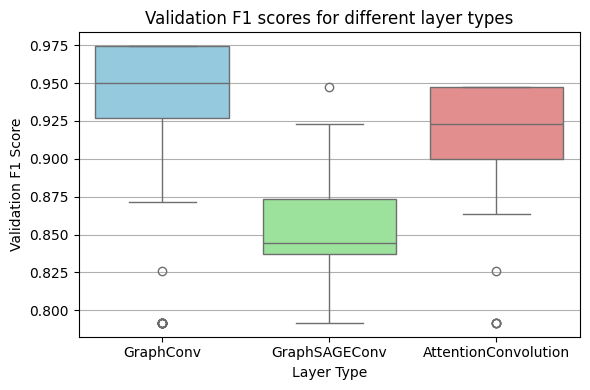

In [49]:
# plotting the F1 scores for each layer type in a boxplot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
colors = ["skyblue", "lightgreen", "lightcoral"]
sns.boxplot(data=nodes_edges_data, x='layer_type', y='val_f1', ax=ax, hue='layer_type', palette=colors, legend=False)
ax.set_title("Validation F1 scores for different layer types")
ax.set_xlabel("Layer Type")
ax.set_ylabel("Validation F1 Score")
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

From the boxplots we can see that the median F1 score for the GraphConv layer is the highest among the three layer types. This boxplot indicates consistent performance across different hyperparameter combinations. The median F1 score for the GraphSAGE layer is the lowest among the three. Its distribution is also wider which indicates a greater variability in performance. The AttentionConvolution boxplot indicates a performance range that's between the other two, with its median F1 score being between the other two layer types.

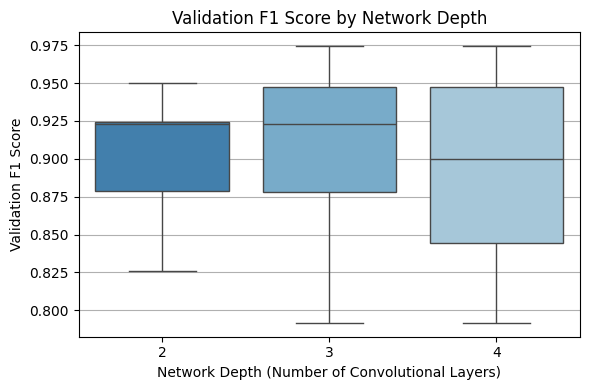

In [50]:
# plotting the F1 scores for each network depth in a boxplot
nodes_edges_data['conv_depth'] = nodes_edges_data['conv_dims'].apply(lambda x: len(eval(x)))
plt.figure(figsize=(6, 4))
sns.boxplot(data=nodes_edges_data, x="conv_depth", y="val_f1", palette="tab20c", hue="conv_depth", legend=False)
plt.title("Validation F1 Score by Network Depth")
plt.ylabel("Validation F1 Score")
plt.xlabel("Network Depth (Number of Convolutional Layers)")
plt.gca().yaxis.grid(True)

plt.tight_layout()
plt.show()

As with the case of using only nodes, we can see that networks with three layers typically outperform networks with two layers in terms of overall performance. However, the four layered networks have a mean that is lower than the other two, with a wider distribution, which points to greater variability in performance.

### Performance evaluation
Once we have our best model based on the performance on the *validation* set for using the edge features as well, we can do a final evaluation on the test set to get an idea of its predicting performance on new unseen data.

—————— Simple Model  ——————

In [51]:
# loading the baseline model
baseline_model_nodes_edges = GNN(
    num_features=num_features, 
    num_edge_features=num_edge_features, 
    conv_dims=conv_dims, 
    activation=activation, 
    pooling=pooling, 
    layer_type="GraphConv")
optimizer = optim.Adam(baseline_model_nodes_edges.parameters(), lr=best_params_by_layer_edges['GraphConv'][0]) 
baseline_model_nodes_edges.load_state_dict(torch.load("baseline_nodes_edges_model.pt"))

<All keys matched successfully>

In [52]:
# testing the Simple GNN model that we trained before
test_results_baseline_nodes_edges = test(baseline_model_nodes_edges, criterion, test_loader_edge, 0.5)
print(f"Test Loss: {test_results_baseline_nodes_edges['test_losses'][-1]}")
print(f"Test Accuracy: {test_results_baseline_nodes_edges['test_accuracies'][-1]}")
print(f"Test F1 Score: {test_results_baseline_nodes_edges['test_f1_scores'][-1]}")

Test Loss: 0.4657962314917573
Test Accuracy: 0.8928571428571429
Test F1 Score: 0.9142857142857143


—————— Best model - GraphConv  ——————

In [53]:
# loading the best model for GraphConv layer type
best_nodes_edges_model_GraphConv = GNN(
    num_features=num_features, 
    num_edge_features=num_edge_features,
    conv_dims=best_params_by_layer_edges['GraphConv'][1], 
    activation=activation, 
    dropout=dropout, 
    pooling=best_params_by_layer_edges['GraphConv'][2], 
    layer_type="GraphConv")
optimizer = optim.Adam(best_nodes_edges_model_GraphConv.parameters(), lr=best_params_by_layer_edges['GraphConv'][0]) 
best_nodes_edges_model_GraphConv.load_state_dict(torch.load("best_nodes_edges_model_GraphConv.pt"))

<All keys matched successfully>

In [54]:
test_results_graphconv_nodes_edges = test(best_nodes_edges_model_GraphConv, criterion, test_loader_edge, 0.5)
print(f"Test Loss: {test_results_graphconv_nodes_edges['test_losses'][-1]}")
print(f"Test Accuracy: {test_results_graphconv_nodes_edges['test_accuracies'][-1]}")
print(f"Test F1 Score: {test_results_graphconv_nodes_edges['test_f1_scores'][-1]}")

Test Loss: 0.41325910351172623
Test Accuracy: 0.9285714285714286
Test F1 Score: 0.9500000000000001


—————— GraphSAGE Convolution ——————

In [55]:
# loading the best model for GraphSAGE layer type
best_nodes_edges_model_GraphSAGE = GNN(
    num_features=num_features, 
    num_edge_features=num_edge_features,
    conv_dims=best_params_by_layer_edges['GraphSAGEConv'][1], 
    activation=activation, 
    dropout=dropout, 
    pooling=best_params_by_layer_edges['GraphSAGEConv'][2], 
    layer_type="GraphSAGEConv")
optimizer = optim.Adam(best_nodes_edges_model_GraphSAGE.parameters(), lr=best_params_by_layer_edges['GraphSAGEConv'][0]) 
best_nodes_edges_model_GraphSAGE.load_state_dict(torch.load("best_nodes_edges_model_GraphSAGEConv.pt"))

<All keys matched successfully>

In [56]:
test_results_graphsage_nodes_edges = test(best_nodes_edges_model_GraphSAGE, criterion, test_loader_edge, 0.5)
print(f"Test Loss: {test_results_graphsage_nodes_edges['test_losses'][-1]}")
print(f"Test Accuracy: {test_results_graphsage_nodes_edges['test_accuracies'][-1]}")
print(f"Test F1 Score: {test_results_graphsage_nodes_edges['test_f1_scores'][-1]}")

Test Loss: 0.3238374881171434
Test Accuracy: 0.9285714285714286
Test F1 Score: 0.9473684210526315


—————— Attention Convolution ——————

In [57]:
# loading the best model for AttentionConvolution layer type
best_nodes_edges_model_attention = GNN(
    num_features=num_features, 
    num_edge_features=num_edge_features,
    conv_dims=best_params_by_layer_edges['AttentionConvolution'][1], 
    activation=activation, 
    dropout=dropout, 
    pooling=best_params_by_layer_edges['AttentionConvolution'][2], 
    layer_type="AttentionConvolution")
optimizer = optim.Adam(best_nodes_edges_model_attention.parameters(), lr=best_params_by_layer_edges['AttentionConvolution'][0]) 
best_nodes_edges_model_attention.load_state_dict(torch.load("best_nodes_edges_model_AttentionConvolution.pt"))

<All keys matched successfully>

In [58]:
test_results_attention_nodes_edges = test(best_nodes_edges_model_attention, criterion, test_loader_edge, 0.5)
print(f"Test Loss: {test_results_attention_nodes_edges['test_losses'][-1]}")
print(f"Test Accuracy: {test_results_attention_nodes_edges['test_accuracies'][-1]}")
print(f"Test F1 Score: {test_results_attention_nodes_edges['test_f1_scores'][-1]}")

Test Loss: 0.4775940899604133
Test Accuracy: 0.6785714285714286
Test F1 Score: 0.742857142857143


Let's organize the results in a table for more clearer understanding.

In [59]:
nodes_edges_data_sorted = nodes_edges_data.sort_values(by="val_f1", ascending=False)

layer_results = {}

for layer in best_params_by_layer.keys():
    top_instance = nodes_edges_data_sorted[nodes_edges_data_sorted['layer_type'] == layer].iloc[0]
    layer_results[layer] = {
        'val_f1': top_instance['val_f1'],
        'val_accuracy': top_instance['val_accuracy']
    }

layer_to_variable_mapping = {
    'GraphConv': 'graphconv',
    'GraphSAGEConv': 'graphsage',
    'AttentionConvolution': 'attention'
}

for layer, variable_name in layer_to_variable_mapping.items():
    test_results_var = globals()['test_results_{}_nodes_edges'.format(variable_name)]
    layer_results[layer]['test_f1'] = test_results_var['test_f1_scores'][-1]
    layer_results[layer]['test_accuracy'] = test_results_var['test_accuracies'][-1]

nodes_edges_table_results = pd.DataFrame.from_dict(layer_results, orient='index')
nodes_edges_table_results


,val_f1,val_accuracy,test_f1,test_accuracy
GraphConv,0.974359,0.965517,0.950000,0.928571
GraphSAGEConv,0.947368,0.931034,0.947368,0.928571
AttentionConvolution,0.947368,0.931034,0.742857,0.678571


According to the results, the best performing model with a F1 score of 0.974 on the validation and F1 score of 0.950 on the test set turned out to be the model with GraphConv layers. This aligns with the boxplot analysis, where the GraphConv layer notably had the highest median F1 score.

However, AttentionConvolution has a validation F1 score of 0.947 but drops significantly in its test F1 score to 0.743. The given results suggest that while AttentionConvolution acheved high validation scores, it may not generalize as well to the test set. This suggests potential overfitting or less robust generalization capabilities when compared to the other models.

## Comparison
Comparing the results with those from Part 2 to determine if using edge features improves performance.

__________________________

In order to explore the difference in model performance when integrating edge features in contrast to only using node features, I've plotted the validation F1 scores for various hyperparameter configurations in both scenarios. Each blue 'X' marker on the plot represents a specific set of hyperparameters, with its x-coordinate showing the validation F1 score using only node features and its y-coordinate displaying the score when both node and edge features are used.

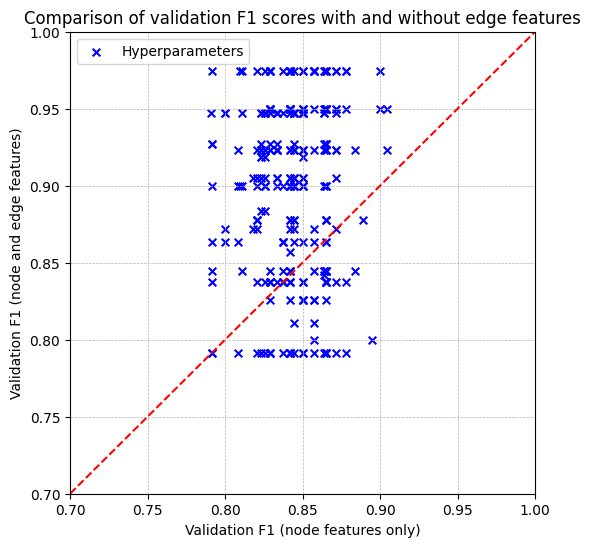

In [60]:
plt.figure(figsize=(6, 6))
# the hyperparameter combinations will be in the same order in both dataframes and we dont have to match them
plt.scatter(nodes_data['val_f1'], nodes_edges_data['val_f1'], color='blue', marker='x', s=30, label='Hyperparameters')  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # y=x line for reference

plt.title('Comparison of validation F1 scores with and without edge features')
plt.xlabel('Validation F1 (node features only)')
plt.ylabel('Validation F1 (node and edge features)')
plt.xlim(0.7, 1)
plt.ylim(0.7, 1)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

Points on the red dashed line (y=x line) indicate that the F1 scores are identical for a specific hyperparameter combination between the two experiments, points above the red dashed line suggest that the model that also uses the edge features has a higher F1 score for that specific hyperparameter combination, and points below the red dashed line indicate that higher F1 score is achieved by using only the node features.

As we can see, most of the data points lie above the dashed red diagonal. This indicates that for most hyperparameter settings, the inclusion of edge features improves the validation F1 score compared to using node features alone.

Also, we can notice that the blue 'X' markers tend to align along specific lines. This can be attributed to the limited number of validation graphs (29). With 19 of the graphs labeled as 1 and the remaining 10 as 0, the range of potential F1 scores is limited. This leads to the formation of distinct lines in the visualization, as multiple hyperparameter configurations end up producing similar F1 scores.

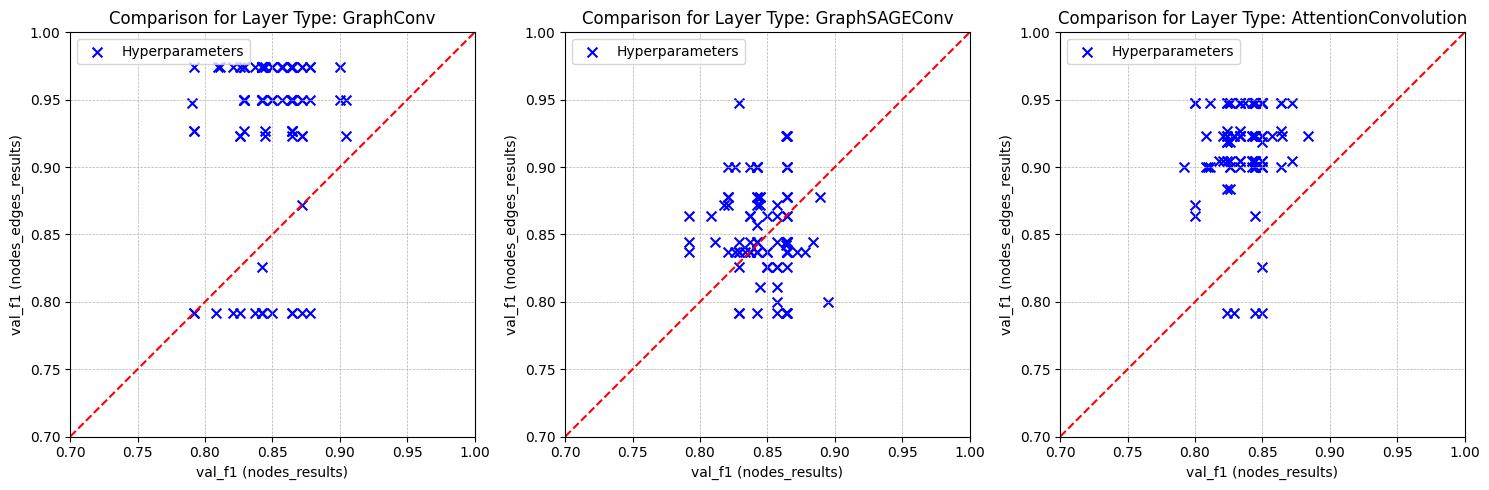

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5)) 

layer_types = nodes_data['layer_type'].unique()

for i, layer in enumerate(layer_types):
    # filtering data for the current layer type
    filtered_nodes = nodes_data[nodes_data['layer_type'] == layer]
    filtered_edges = nodes_edges_data[nodes_edges_data['layer_type'] == layer]
    
    axes[i].scatter(filtered_nodes['val_f1'], filtered_edges['val_f1'], color='blue', marker='x', s=50, label='Hyperparameters')
    axes[i].plot([0, 1], [0, 1], color='red', linestyle='--')  # y=x line for reference
    
    axes[i].set_title(f'Comparison for Layer Type: {layer}')
    axes[i].set_xlabel('val_f1 (nodes_results)')
    axes[i].set_ylabel('val_f1 (nodes_edges_results)')
    axes[i].set_xlim(0.7, 1)
    axes[i].set_ylim(0.7, 1)
    axes[i].legend()
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

Next I separated the results of the three different layer types and again I observed how the models perform with just node features versus both node and edge features. 

- GraphConv - the majority of the points lie above the y=x line which suggests that the edge features are beneficial for models using the GraphConv layer type
- GraphSAGEConv - the spread is more varied, some hyperparameter combinations benefit from the inclusion of edge features while others don't
- AttentionConvolution - we can see a clearer difference since almost all points lie noticeably above the y=x line, suggesting that for many hyperparameter combinations incorporating edge features results in a better F1 score compared to using just the node features

It is also important to see which class does the model predict correctly and which one it misclassifies. To see this we'll plot the confusion matrices for every model over the predictions from the test set.

In [62]:
def plot_confusion_matrix(confusion_matrix, title, ax):
    muted_blues = sns.light_palette("blue", as_cmap=True)
    
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap=muted_blues, cbar=False,
                xticklabels=['NON MUTAGENIC', 'MUTAGENIC'],
                yticklabels=['NON MUTAGENIC', 'MUTAGENIC'],
                ax=ax, annot_kws={"size": 15})  
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(title)

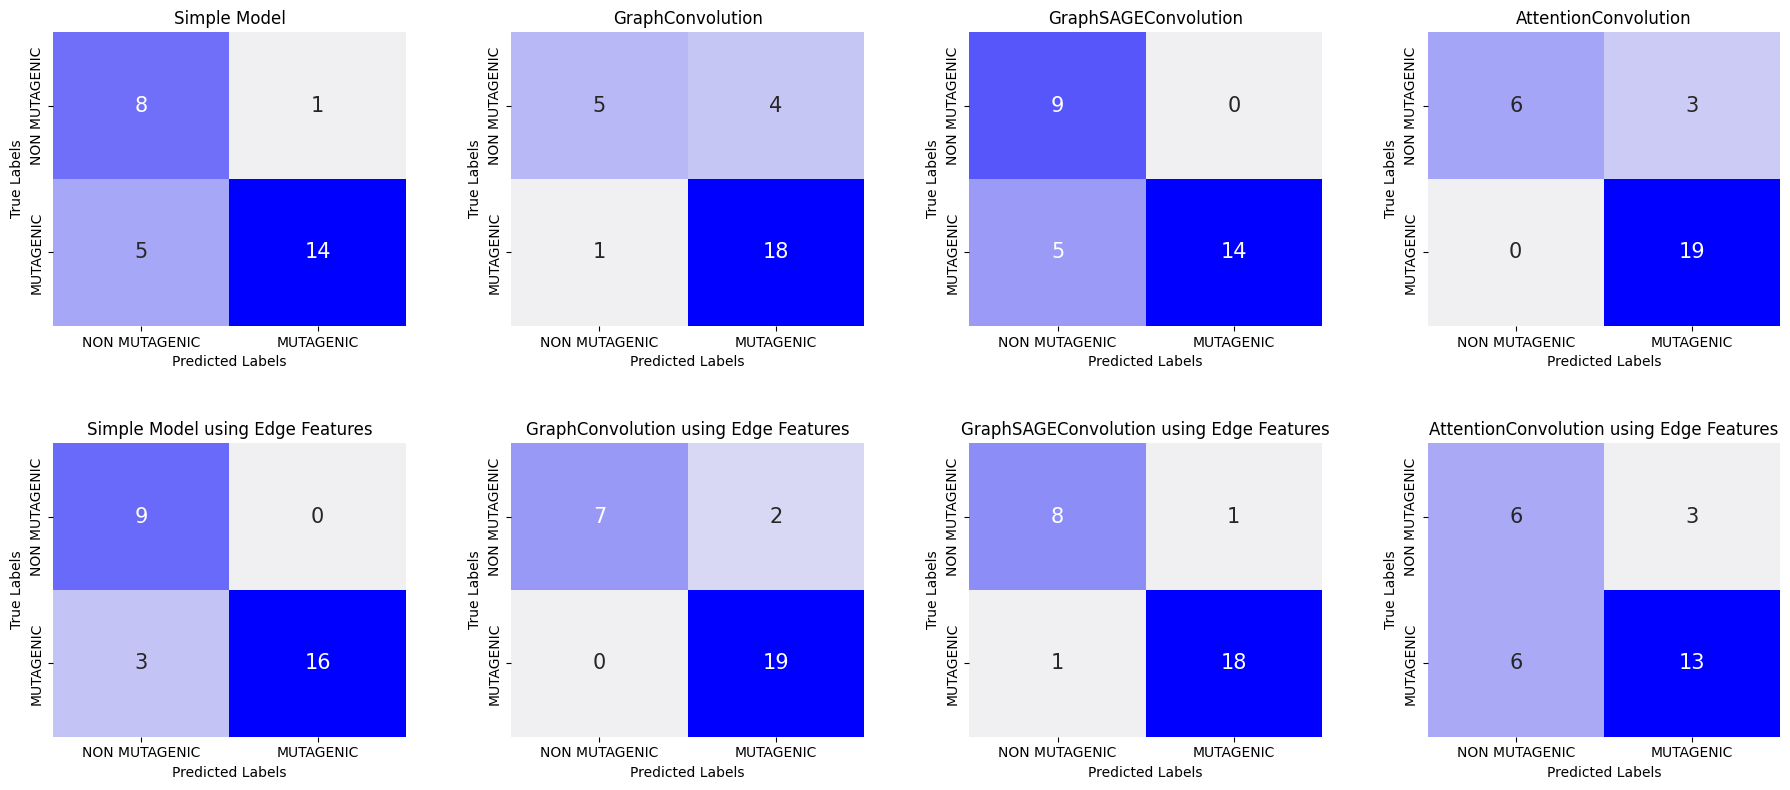

In [63]:
matrices = [
    test_results_baseline_nodes['test_confusion_matrix'], test_results_graphconv_nodes['test_confusion_matrix'],
    test_results_graphsage_nodes['test_confusion_matrix'], test_results_attention_nodes['test_confusion_matrix'],
    test_results_baseline_nodes_edges['test_confusion_matrix'], test_results_graphconv_nodes_edges['test_confusion_matrix'],
    test_results_graphsage_nodes_edges['test_confusion_matrix'], test_results_attention_nodes_edges['test_confusion_matrix'],
    ]

titles = [
    "Simple Model", "GraphConvolution", 
    "GraphSAGEConvolution", "AttentionConvolution",
    "Simple Model using Edge Features", "GraphConvolution using Edge Features", 
    "GraphSAGEConvolution using Edge Features", "AttentionConvolution using Edge Features",
    ]

fig, axes = plt.subplots(2, 4, figsize=(18, 8))

for ax, matrix, title in zip(axes.ravel(), matrices, titles):
    plot_confusion_matrix(matrix, title, ax)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()


The addition of edge features generally improves the performance, especially when classifying non mutagenic compounds. All models have noticeable improvements in their predictions exept for AttentionConvolution, where the inclusion of edge features ruins the perfectly classified mutagenic class, but maintainins a similar classification for the non mutagenic class.

Finally, we can visualize the progression of the F1 score as we enhance our GNN models.

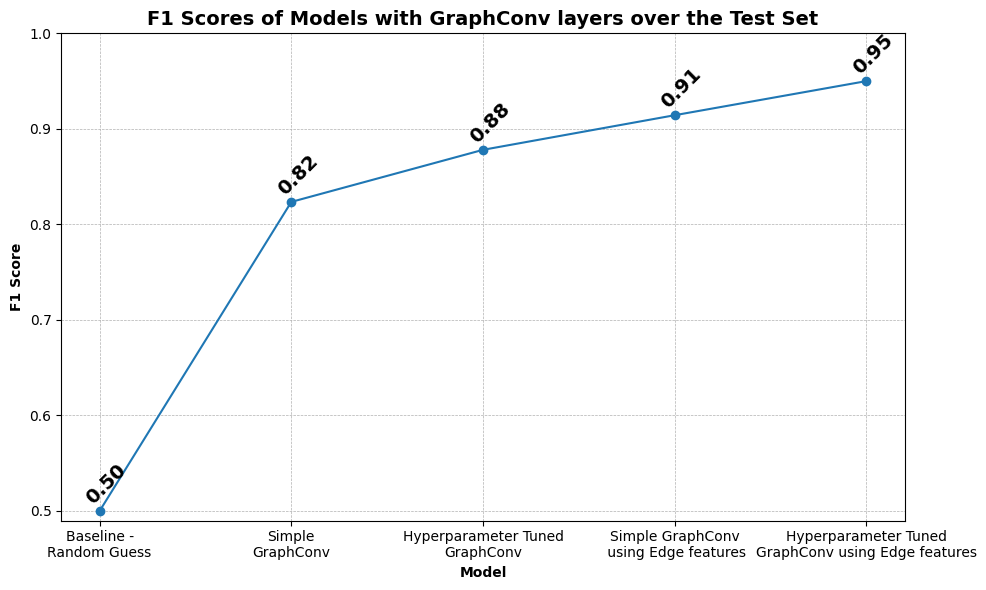

In [64]:
models = [
    'Baseline -\nRandom Guess', 
    'Simple\nGraphConv', 
    'Hyperparameter Tuned\nGraphConv', 
    'Simple GraphConv\n using Edge features', 
    'Hyperparameter Tuned\nGraphConv using Edge features']

f1_scores = [
    0.5, 
    test_results_baseline_nodes['test_f1_scores'][-1], 
    test_results_graphconv_nodes ['test_f1_scores'][-1], 
    test_results_baseline_nodes_edges['test_f1_scores'][-1], 
    test_results_graphconv_nodes_edges['test_f1_scores'][-1]]  


plt.figure(figsize=(10, 6))
plt.plot(models, f1_scores, marker='o', linestyle='-')
plt.title('F1 Scores of Models with GraphConv layers over the Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontweight='bold')
plt.ylabel('F1 Score', fontweight='bold')
plt.xticks(rotation=0, ha='center', fontsize=10) 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(0.49, 1)

for i, txt in enumerate(f1_scores):
    plt.annotate(f"{txt:.2f}",  
                 (i, txt),     
                 textcoords="offset points", 
                 fontweight='bold',
                 xytext=(5,5),  
                 ha='center', 
                 fontsize=14,   
                 rotation=45)  

plt.tight_layout()
plt.show()


The graph illustrates the F1 scores of different GNN models with GraphConv layers over the test set. A clear observation is the impact of utilizing edge features in the GNN. Both models that use the edge features in addition to the node features have improvement in F1 score compared to the ones that don't use them. Also, the significance of hyperparameter tuning is evident. For both models - with and without edge features — the hyperparameter-tuned models consistently outperform the simple models. This highlights the importance of model optimization to achieve peak performance.

In summary, incorporating edge features and hyperparameter tuning are key to improving the results.